# Converting each MOF to a graph
* reads in each MOF from DDEC charge-assigned dataset
* infers bonds using distance-based criterion
* writes to file: 
    * list of crystal names: `list_of_crystals.txt`
    * node features: `graphs/xtalname_node_features.npy`
    * edge list and features: `graphs/xtalname.edge_info`. the edges are 0-based indexed.
    * node labels (charges) `graphs/xtalname_node_labels.npy`

In [43]:
using PorousMaterials # use major_refactor branch.
using DataFrames
using PyPlot
using NPZ
using CSV
using LightGraphs
using LinearAlgebra
using Logging
using Printf
using DelimitedFiles
using ProgressMeter
using PyCall
push!(LOAD_PATH, pwd()) # to see Bonds.jl
using Bonds
using Statistics

# global_logger(Logging.SimpleLogger(stdout, Logging.Info)) # to print @debug put Logging.Debug
global_logger(Logging.SimpleLogger(stdout, Logging.Debug)) # to print @debug put Logging.Debug

Base.CoreLogging.SimpleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(Base.Libc.WindowsRawSocket(0x0000000000000394) open, 0 bytes waiting))), Debug, Dict{Any,Int64}((Ptr{Nothing} @0x000000003d3eee74, :getindex) => 0))

### get list of MOFs
MOF `.cif` files with DDEC-assigned charges are found in `xtals/`. These were downloaded from [here](https://github.com/gregchung/gregchung.github.io/blob/master/CoRE-MOFs/core-mof-1.0-ddec.tar). The paper corresponding to these structures is [here](https://pubs.acs.org/doi/abs/10.1021/acs.chemmater.5b03836).

In [44]:
@eval PorousMaterials PATH_TO_CRYSTALS = joinpath(pwd(), "xtals")

"C:\\Users\\Arni\\Documents\\GitHub\\mpn_charges\\build_graphs\\xtals"

In [45]:
xtalnames = map(x -> replace(x, ".cif" => ""), readdir("xtals"))

2932-element Array{String,1}:
 "ABAVIJ_clean"
 "ABAVOP_clean"
 "ABEXIQ_clean"
 "ABEXOW_clean"
 "ABEXUC_clean"
 "ABEYAJ_clean"
 "ABEYIR"
 "ABIYIV"
 "ABUWOJ_clean"
 "ACAKUM"
 "ACALIB_clean"
 "ACODED"
 "ACOLIP_clean"
 ⋮
 "ZILBAZ_clean"
 "ZILBED_clean"
 "ZIMJOW_clean"
 "ZISYAD_clean"
 "ZNGLUD01_clean"
 "ZNGLUD_clean"
 "ZURQOS_clean"
 "Zn-DOBDC"
 "ZnBDC"
 "ZnBDCdabco"
 "ZnHBDC"
 "ZnMOF-74"

### Lets remove duplicate structures from the data set.

`duplicates.csv` is a table from Nazarian et al. (DOI: 10.1021/acs.chemmater.5b03836)

In [46]:
all_structures = CSV.read("duplicates.csv")
unique_structures = all_structures[:,1]

4297-element WeakRefStrings.StringArray{String,1}:
 "Cu-BTC"
 "EDUSIF_clean"
 "CIWRAC_clean"
 "GIKMOD01_clean"
 "FIQYOU_clean"
 "ITIWIS_charged"
 "ATIBAG_clean"
 "OKITIM01_charged"
 "FARFIO_clean"
 "IDIWOH"
 "FIJDIM01_clean"
 "MECWEX_manual"
 "BAHGUN01_clean"
 ⋮
 "FALQIU_clean"
 "WAMRIN02_clean"
 "OVEJIJ_clean"
 "UNABIV_charged"
 "ZIF-97"
 "WAWGOQ_clean"
 "IZEPAF_clean"
 "ZIF-93"
 "SAPJEA_charged"
 "DEYNIG_clean"
 "GAHWIX_clean"
 "WENSIS_clean"

In [69]:
set_of_unique_xtals = Set(unique_structures)
set_of_ddec_xtals = Set(xtalnames)
set_of_unique_ddec_xtals = intersect(set_of_unique_xtals, set_of_ddec_xtals)
length(set_of_unique_ddec_xtals)

2285

In [48]:
for (i, unique_xtal) in enumerate(unique_structures)
    if ! in(unique_xtal, set_of_ddec_xtals)
        other_xtals = all_structures[i, 2:end]
        if length(intersect(set_of_ddec_xtals, Set(other_xtals))) > 0
            have_i_added_another_crystal = false
            @warn @sprintf("%s is not in the DDEC set but...\n", unique_xtal)
            for (j, duplicate_xtal) in enumerate(other_xtals)
                if ismissing(duplicate_xtal)
                    break
                end
                if duplicate_xtal in xtalnames
                    if ! have_i_added_another_crystal
                        push!(set_of_unique_ddec_xtals, duplicate_xtal)
                        have_i_added_another_crystal = true
                    end
                    @printf("\t%s is in the set\n", duplicate_xtal)
                end
            end
        end
    end
end

┌ Warning: Cu-BTC is not in the DDEC set but...
└ @ Main In[48]:6
	DOTSOV02_clean is in the set
	DOTSOV03_clean is in the set
	DOTSOV04_clean is in the set
	DOTSOV05_clean is in the set
	DOTSOV06_clean is in the set
	DOTSOV07_clean is in the set
	DOTSOV08_clean is in the set
	DOTSOV09_clean is in the set
	DOTSOV10_clean is in the set
	DOTSOV11_clean is in the set
	DOTSOV12_clean is in the set
	DOTSOV13_clean is in the set
	DOTSOV14_clean is in the set
	DOTSOV15_clean is in the set
	DOTSOV16_clean is in the set
	DOTSOV18_clean is in the set
	DOTSOV19_clean is in the set
	DOTSOV20_clean is in the set
	DOTSOV21_clean is in the set
	DOTSOV22_clean is in the set
	DOTSOV23_clean is in the set
	DOTSOV24_clean is in the set
	DOTSOV25_clean is in the set
	DOTSOV26_clean is in the set
	DOTSOV27_clean is in the set
	DOTSOV28_clean is in the set
	DOTSOV29_clean is in the set
	DOTSOV30_clean is in the set
	DOTSOV31_clean is in the set
	DOTSOV32_clean is in the set
	DOTSOV33_clean is in the set
	DOT

In [49]:
xtalnames = collect(set_of_unique_ddec_xtals)

2325-element Array{String,1}:
 "SEHSUU_clean"
 "CECVOW_clean"
 "WEMFAX_clean"
 "MAQZOV_clean"
 "GIQXIO_clean"
 "LUSHIR_clean"
 "ALIXUP_clean"
 "LUSJAL_clean"
 "MAFZOK_clean"
 "MAKSUO_clean"
 "QOKCID_clean"
 "WAMRIN01_clean"
 "POKXIX_clean"
 ⋮
 "LAGNOY_clean"
 "ESEQUO_clean"
 "ISUXAW_clean"
 "KASRAZ_clean"
 "WEMFOL_clean"
 "BIVXEK_clean"
 "RIVDEF_clean"
 "KABXES_clean"
 "AVEMOE_clean"
 "AVUDAX_clean"
 "CUYQIX_clean"
 "GIYTIS_clean"

### find unique atomic species

In [50]:
unique_atomic_species = Set{Symbol}()

for xtalname in xtalnames
    crystal = Crystal(xtalname * ".cif")
    for a in unique(crystal.atoms.species)
        push!(unique_atomic_species, a)
    end
end
unique_atomic_species

println("# unique atomic species: ", length(unique_atomic_species))

# unique atomic species: 74


### analyze occurance of atomic species in MOFs
i.e., how many MOFs contain atom $i$? this is important to ensure we can adequately learn charges on rare MOF atoms.

In [51]:
species_occurance = Dict{Symbol, Int}(a => 0 for a in unique_atomic_species)
for xtalname in xtalnames
    crystal = Crystal(xtalname * ".cif")
    for a in unique(crystal.atoms.species)
        species_occurance[a] += 1
    end
end
species_occurance

Dict{Symbol,Int64} with 74 entries:
  :Cl => 70
  :Al => 19
  :Be => 2
  :Re => 5
  :Cr => 16
  :Na => 36
  :Sb => 2
  :Ni => 111
  :S  => 179
  :Ru => 10
  :Tm => 17
  :W  => 14
  :Nd => 78
  :O  => 2050
  :Th => 4
  :F  => 69
  :Co => 237
  :Gd => 64
  :Rh => 2
  :Pu => 1
  :Ca => 39
  :N  => 1472
  :Yb => 25
  :As => 2
  :Se => 1
  ⋮   => ⋮

put in a `DataFrame` for sorting and plotting

In [52]:
df_species_occurance = DataFrame(atom=collect(keys(species_occurance)), 
                                 nb_mofs=collect(values(species_occurance))
                                 )
sort!(df_species_occurance, :nb_mofs)
first(df_species_occurance, 6)

,atom,nb_mofs
,Symbol,Int64
1,Pu,1
2,Se,1
3,Hf,1
4,Ir,1
5,Be,2
6,Sb,2


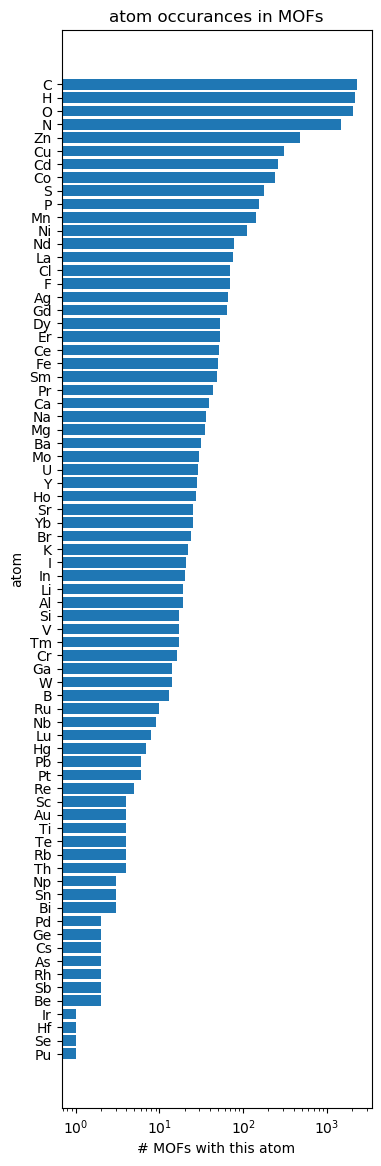

PyObject Text(0.5, 1, 'atom occurances in MOFs')

In [53]:
figure(figsize=(4, 14))
barh(1:nrow(df_species_occurance), df_species_occurance[:, :nb_mofs])
yticks(1:nrow(df_species_occurance), df_species_occurance[:, :atom])
xlabel("# MOFs with this atom")
ylabel("atom")
xscale("log")
title("atom occurances in MOFs")

### atom <--> integer mapping for one-hot encoding

sort my occurance

In [54]:
sort!(df_species_occurance, :nb_mofs, rev=true)
const ATOMS = deepcopy(df_species_occurance[:, :atom])
ATOMS

74-element Array{Symbol,1}:
 :C
 :H
 :O
 :N
 :Zn
 :Cu
 :Cd
 :Co
 :S
 :P
 :Mn
 :Ni
 :Nd
 ⋮
 :Np
 :Be
 :Sb
 :Rh
 :As
 :Cs
 :Ge
 :Pd
 :Pu
 :Se
 :Hf
 :Ir

In [55]:
const ATOM_TO_INT = Dict{Symbol, Int}(a => i for (i, a) in enumerate(ATOMS))
ATOM_TO_INT

Dict{Symbol,Int64} with 74 entries:
  :Cl => 15
  :Al => 39
  :Re => 54
  :Be => 64
  :Cr => 44
  :Na => 26
  :Sb => 65
  :Ni => 12
  :S  => 9
  :Ru => 48
  :Tm => 41
  :W  => 45
  :Nd => 13
  :O  => 3
  :Th => 55
  :F  => 16
  :Co => 8
  :Gd => 18
  :Rh => 66
  :Pu => 71
  :Ca => 25
  :N  => 4
  :Yb => 33
  :As => 67
  :Se => 72
  ⋮   => ⋮

In [56]:
CSV.write("atom_to_int.csv", ATOM_TO_INT)

"atom_to_int.csv"

### write graph structure, edge features, node features, and node labels to file for each MOF

In [57]:
isdir("graphs") ? nothing : mkdir("graphs")
metals = [:Li, :Na, :K, :Rb, :Cs, :Fr, #Alkali metals
          :Be, :Mg, :Ca, :Sr, :Ba, :Ra, #Alkaline earth metals
          :Sc, :Ti, :V, :Cr, :Mn, :Fe, :Co, :Ni, :Cu, :Zn,
          :Y, :Zr, :Nb, :Mo, :Tc, :Ru, :Rh, :Pd, :Ag, :Cd,
          :Hf, :Ta, :W, :Re, :Os, :Ir, :Pt, :Au, :Hg,
          :Rf, :Db, :Sg, :Bh, :Hs, :Cn, #Transition metals
          :Al, :Ga, :In, :Sn, :Tl, :Pb, :Bi, :Po, :Fl, #Post-transition metals
          :La, :Ce, :Pr, :Nd, :Pm, :Sm, :Eu, :Gd, :Tb, :Dy, :Ho, :Er, :Tm, :Yb, :Lu, #Lanthanoids
          :Ac, :Th, :Pa, :U, :Np, :Pu, :Am, :Cm, :Bk, :Cf, :Es, :Fm, :Md, :No, :Lr] #Actinoids

86-element Array{Symbol,1}:
 :Li
 :Na
 :K
 :Rb
 :Cs
 :Fr
 :Be
 :Mg
 :Ca
 :Sr
 :Ba
 :Ra
 :Sc
 ⋮
 :U
 :Np
 :Pu
 :Am
 :Cm
 :Bk
 :Cf
 :Es
 :Fm
 :Md
 :No
 :Lr

In [58]:
charge_list = Dict(atom => Float64[] for atom in keys(ATOM_TO_INT))

for (i_xtal, xtalname) in enumerate(xtalnames)
    xtal = Crystal(xtalname * ".cif", include_zero_charges=true)
    for (j, atom) in enumerate(xtal.atoms.species)
        append!(charge_list[atom], xtal.charges.q[j])
    end
end

In [59]:
atoms = []
σ = []
for x in keys(charge_list)
    push!(atoms, x)
    push!(σ, std(charge_list[x]))
end
stdev_df = DataFrame(Dict(:element => atoms, :stdev => σ))
CSV.write("stdev.csv", stdev_df)

"stdev.csv"

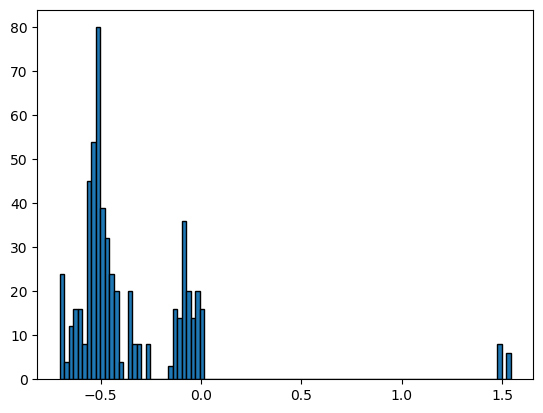

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [60]:
fig, ax = plt.subplots()
ax.hist(charge_list[:Cl], bins=100, ec="k")
plt.show()

In [61]:
INT_TO_ATOM = Dict(value => key for (key, value) in ATOM_TO_INT)
mean_charges = zeros(length(charge_list))
for i = 1:74
    mean_charges[i] = mean(charge_list[INT_TO_ATOM[i]])
end

In [62]:
INT_TO_ATOM[74]

:Ir

In [63]:
mean_charge_df = DataFrame(:mean_charge => mean_charges, :atom => [INT_TO_ATOM[i] for i = 1:74])

,mean_charge,atom
,Float64,Symbol
1,0.0909217,C
2,0.117561,H
3,-0.63384,O
4,-0.303676,N
5,0.940772,Zn
6,0.665301,Cu
7,0.956287,Cd
8,0.933813,Co
9,0.329906,S


In [64]:
mean_charge_dict = Dict()
for row in 1:size(mean_charge_df)[1]
    mean_charge_dict[Symbol(mean_charge_df[!, :atom][row])] = mean_charge_df[!, :mean_charge][row]
end

In [65]:
CSV.write("mean_charges.csv", mean_charge_df)

"mean_charges.csv"

In [66]:
AD = []

@showprogress for (i_xtal, xtalname) in enumerate(xtalnames)
    crystal = Crystal(xtalname * ".cif", include_zero_charges=true)
    @assert ! all(crystal.charges.q .== 0)
    new_charge_list = [0 for atom in crystal.atoms.species]
    net_charge = sum(new_charge_list)
    new_charge_list = new_charge_list .- net_charge/length(new_charge_list)
    for i in 1:length(new_charge_list)
        push!(AD, abs(new_charge_list[i] - crystal.charges.q[i]))
    end
end


Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


In [67]:
sum(AD)/length(AD)

0.15366594540255954

In [ ]:
@info "making edge list zero-based indexed for Python"

keep_xtal = [true for i = 1:length(xtalnames)]
metal_coordination = Dict(xtal => [] for xtal in metals)
KEEP_TRACK_OF_COORDINATION = true

@showprogress for (i_xtal, xtalname) in enumerate(xtalnames)
    crystal = Crystal(xtalname * ".cif", include_zero_charges=true)
    @assert ! all(crystal.charges.q .== 0)
    try
        bonds!(crystal, true)
    catch e
        if isa(e, PyCall.PyError)
            remove_bonds!(crystal) # some of the bonds were probz formed
            println("Voronoi problems with " * crystal.name)
            infer_bonds!(crystal, true) # infer bonds with old distance-based version
        else
            error("bond! error for " * crystal.name)
        end
    end
    @assert nv(crystal.bonds) == crystal.atoms.n
    
    if ! PorousMaterials.bond_sanity_check(crystal)
        keep_xtal[i_xtal] = false
        @warn "throwing out " crystal.name
        continue
    end
    
    ###
    #    node features
    #    one-hot encoding. each row is an atom.
    ###
    x_ν = zeros(Int, crystal.atoms.n, length(ATOMS))
    for (i, atom) in enumerate(crystal.atoms.species)
        x_ν[i, ATOM_TO_INT[atom]] = 1
    end
    @assert sum(x_ν) == crystal.atoms.n
    npzwrite(joinpath("graphs", xtalname * "_node_features.npy"), x_ν)

    ###
    #    node labels (the charges)
    ###
    y_ν = deepcopy(crystal.charges.q)
    npzwrite(joinpath("graphs", xtalname * "_node_labels.npy"), y_ν)
    @assert length(y_ν) == size(x_ν)[1]

    ###
    #   edges
    #   (a list and their feature = distance btwn atoms)
    ###
    edge_file = open(joinpath("graphs", xtalname * ".edge_info"), "w")
    @printf(edge_file, "src,dst,r\n")
    for ed in edges(crystal.bonds)
        i = src(ed) # source
        j = dst(ed) # destination
        r = distance(crystal.atoms, crystal.box, i, j, true)
        @printf(edge_file, "%d,%d,%f\n", i - 1, j - 1, r)
    end
    close(edge_file)
            
    if KEEP_TRACK_OF_COORDINATION
        for (i, a) in enumerate(crystal.atoms.species)
            if a in metals
                push!(metal_coordination[a], length(neighbors(crystal.bonds, i)))
            end
        end
    end
end

writedlm(open("list_of_crystals.txt", "w"), xtalnames[keep_xtal])

In [ ]:
mean_coordination_df = DataFrame(:coordination => mean_charges, :atom => [INT_TO_ATOM[i] for i = 1:74])

In [ ]:
if KEEP_TRACK_OF_COORDINATION
    for metal in metals
        if length(metal_coordination[metal]) == 0
            continue
        end
        fig, ax = plt.subplots(figsize=(6,6))
        ax.hist(metal_coordination[metal], bins=collect(0:11), align="left", fc="#911eb4", ec="k")
        ax.set_xlabel("Coordination number")
        ax.set_ylabel("Count")
        ax.set_title(String(metal))
        plt.tight_layout()
        plt.show()
    end
end

In [ ]:
@info "making edge list zero-based indexed for Python"

nb_graphs = [0 for i = 1:length(xtalnames)]

@showprogress for (i_xtal, xtalname) in enumerate(xtalnames)
    crystal = Crystal(xtalname * ".cif", include_zero_charges=true)
    @assert ! all(crystal.charges.q .== 0)
    crystal = replicate(crystal, (2,2,2))
    try
        bonds!(crystal, true)
    catch e
        if isa(e, PyCall.PyError)
            remove_bonds!(crystal) # some of the bonds were probz formed
            println("Voronoi problems with " * crystal.name)
            infer_bonds!(crystal, true) # infer bonds with old distance-based version
        else
            error("bond! error for " * crystal.name)
        end
    end
    @assert nv(crystal.bonds) == crystal.atoms.n
    
    if ! PorousMaterials.bond_sanity_check(crystal)
        keep_xtal[i_xtal] = false
        @warn "throwing out " crystal.name
        continue
    end
            
    nb_graphs[i_xtal] = length(connected_components(crystal.bonds))
end

In [ ]:
sorted_list_of_components = sortperm(nb_graphs, rev=true)
for idx in sorted_list_of_components
    @printf("%s\t%d\n", xtalnames[idx], nb_graphs[idx])
end
#xtalnames[sorted_list_of_components]

In [ ]:
println("threw out ", sum(.! keep_xtal), )

In [ ]:
f = open("list_of_crystals.txt", "w")
writedlm(f, xtalnames[keep_xtal])
close(f)

# viz an example structure

In [ ]:
xtal = "ALUKIC_clean.cif"
xtal = Crystal(xtal)
write_vtk(xtal, center_at_origin=true)

xtal = replicate(xtal, (1, 1, 1))

try
    bonds!(xtal, true)
catch e
    if isa(e, PyCall.PyError)
        remove_bonds!(xtal) # some of the bonds were probz formed
        println("Voronoi problems with " * xtal.name)
        infer_bonds!(xtal, true) # infer bonds with old distance-based version
    else
        error("bond! error for " * xtal.name)
    end
end

if ! is_connected(xtal.bonds)
    println("not connected")
end

write_xyz(vv_xtal, center_at_origin=true)
write_bond_information(vv_xtal, center_at_origin=true)

In [ ]:
duplicate_structures = CSV.read("duplicates.csv")
unique_structures = duplicate_structures[:,1]

In [ ]:
set_of_unique_xtals = Set(unique_structures)

In [ ]:
set_of_ddec_xtals = Set(xtalnames)

In [ ]:
@show length(set_of_ddec_xtals)
non_duplicate_xtalnames = intersect(set_of_unique_xtals, set_of_ddec_xtals)
@show length(non_duplicate_xtalnames)

In [ ]:
for (i, unique_xtal) in enumerate(unique_structures)
    if ! in(unique_xtal, set_of_ddec_xtals)
        other_xtals = duplicate_structures[i, 2:end]
        if length(intersect(set_of_ddec_xtals, Set(other_xtals))) > 0
            @warn @sprintf("%s is not in the DDEC set but...\n", unique_xtal)
            for (j, duplicate_xtal) in enumerate(other_xtals)
                if ismissing(duplicate_xtal)
                    break
                end
                if duplicate_xtal in xtalnames
                    if j == 1
                        push!(set_of_unique_xtals, duplicate_xtal)
                    end
                    @printf("\t%s is in the set\n", duplicate_xtal)
                end
            end
        end
    end
end

In [ ]:
non_duplicate_xtalnames = intersect(set_of_unique_xtals, set_of_ddec_xtals)
@show length(non_duplicate_xtalnames)

In [ ]:
non_duplicate_xtalnames

In [ ]:
isdir("non_duplicate_graphs3") ? nothing : mkdir("non_duplicate_graphs3")

In [ ]:
@info "making edge list zero-based indexed for Python"

keep_xtal = [true for i = 1:length(non_duplicate_xtalnames)]
old_system = [true for i = 1:length(non_duplicate_xtalnames)]
non_duplicate_xtalnames = collect(non_duplicate_xtalnames)

@showprogress for (i_xtal, xtalname) in enumerate(non_duplicate_xtalnames)
    crystal = Crystal(xtalname * ".cif", include_zero_charges=true)
    @assert ! all(crystal.charges.q .== 0)
    try
        bonds!(crystal, true)
    catch e
        if isa(e, PyCall.PyError)
            remove_bonds!(crystal) # some of the bonds were probz formed
            println("Voronoi problems with " * crystal.name)
            infer_bonds!(crystal, true) # infer bonds with old distance-based version
            old_system[i_xtal] = false
        else
            error("bond! error for " * crystal.name)
        end
    end
    @assert nv(crystal.bonds) == crystal.atoms.n
    
    if ! PorousMaterials.bond_sanity_check(crystal)
        keep_xtal[i_xtal] = false
        @warn "throwing out " crystal.name
        continue
    end
    
    ###
    #    node features
    #    one-hot encoding. each row is an atom.
    ###
    x_ν = zeros(Int, crystal.atoms.n, length(ATOMS))
    for (i, atom) in enumerate(crystal.atoms.species)
        x_ν[i, ATOM_TO_INT[atom]] = 1
    end
    @assert sum(x_ν) == crystal.atoms.n
    npzwrite(joinpath("non_duplicate_graphs3", xtalname * "_node_features.npy"), x_ν)

    ###
    #    node labels (the charges)
    ###
    y_ν = deepcopy(crystal.charges.q)
    npzwrite(joinpath("non_duplicate_graphs3", xtalname * "_node_labels.npy"), y_ν)
    @assert length(y_ν) == size(x_ν)[1]

    ###
    #   edges
    #   (a list and their feature = distance btwn atoms)
    ###
    edge_file = open(joinpath("non_duplicate_graphs3", xtalname * ".edge_info"), "w")
    @printf(edge_file, "src,dst,r\n")
    for ed in edges(crystal.bonds)
        i = src(ed) # source
        j = dst(ed) # destination
        r = distance(crystal.atoms, crystal.box, i, j, true)
        @printf(edge_file, "%d,%d,%f\n", i - 1, j - 1, r)
    end
    close(edge_file)
end

writedlm(open("non_duplicate_list_of_crystals3.txt", "w"), non_duplicate_xtalnames[keep_xtal])

In [ ]:
sum(keep_xtal .== 0)

In [ ]:
@info "making edge list zero-based indexed for Python"

nb_graphs = [0 for i = 1:length(non_duplicate_xtalnames)]
keep_xtal = [true for i = 1:length(non_duplicate_xtalnames)]

@showprogress for (i_xtal, xtalname) in enumerate(non_duplicate_xtalnames)
    crystal = Crystal(xtalname * ".cif", include_zero_charges=true)
    @assert ! all(crystal.charges.q .== 0)
    crystal = replicate(crystal, (2,2,2))
    try
        bonds!(crystal, true)
    catch e
        if isa(e, PyCall.PyError)
            remove_bonds!(crystal) # some of the bonds were probz formed
            println("Voronoi problems with " * crystal.name)
            infer_bonds!(crystal, true) # infer bonds with old distance-based version
        else
            error("bond! error for " * crystal.name)
        end
    end
    @assert nv(crystal.bonds) == crystal.atoms.n
    
    if ! PorousMaterials.bond_sanity_check(crystal)
        keep_xtal[i_xtal] = false
        @warn "throwing out " crystal.name
        continue
    end
            
    nb_graphs[i_xtal] = length(connected_components(crystal.bonds))
end

In [ ]:
sorted_list_of_components = sortperm(nb_graphs, rev=true)
for idx in sorted_list_of_components
    @printf("%s\t%d\n", non_duplicate_xtalnames[idx], nb_graphs[idx])
end
#xtalnames[sorted_list_of_components]
duplicate_df2 = DataFrame(:xtal => non_duplicate_xtalnames[sorted_list_of_components], :nb_graph => nb_graphs[sorted_list_of_components])
CSV.write("new_xtal_list.csv", duplicate_df2)

In [ ]:
sum(keep_xtal)

# Deployment Set (CoRE-2019-ASR)

In [ ]:
@eval PorousMaterials PATH_TO_CRYSTALS = joinpath(pwd(), "structure_10143")

In [ ]:
xtalnames = map(x -> replace(x, ".cif" => ""), readdir("structure_10143"))

In [ ]:
isdir("deployment_graphs") ? nothing : mkdir("deployment_graphs")

### find unique atomic species

In [ ]:
unique_atomic_species = Set{Symbol}()

for xtalname in xtalnames
    crystal = Crystal(xtalname * ".cif", check_overlap=false)
    strip_numbers_from_atom_labels!(crystal)
    for a in unique(crystal.atoms.species)
        push!(unique_atomic_species, a)
    end
end
unique_atomic_species

println("# unique atomic species: ", length(unique_atomic_species))

### analyze occurance of atomic species in MOFs
i.e., how many MOFs contain atom $i$? this is important to ensure we can adequately learn charges on rare MOF atoms.

In [ ]:
species_occurance = Dict{Symbol, Int}(a => 0 for a in unique_atomic_species)
for xtalname in xtalnames
    crystal = Crystal(xtalname * ".cif", check_overlap=false)
    strip_numbers_from_atom_labels!(crystal)
    for a in unique(crystal.atoms.species)
        species_occurance[a] += 1
    end
end
species_occurance

In [ ]:
@info "making edge list zero-based indexed for Python"

keep_xtal = [true for i = 1:length(xtalnames)]

@showprogress for (i_xtal, xtalname) in enumerate(xtalnames)
    crystal = Crystal(xtalname * ".cif", include_zero_charges=true, check_overlap=false)
    strip_numbers_from_atom_labels!(crystal)
    if ! all([atom_species in keys(ATOM_TO_INT) for atom_species in crystal.atoms.species])
        keep_xtal[i_xtal] = false
        continue
    end
    
    
    try
        bonds!(crystal, true)
    catch e
        if isa(e, PyCall.PyError)
            remove_bonds!(crystal) # some of the bonds were probz formed
            println("Voronoi problems with " * crystal.name)
            infer_bonds!(crystal, true) # infer bonds with old distance-based version
        else
            error("bond! error for " * crystal.name)
        end
    end
    if nv(crystal.bonds) != crystal.atoms.n
        keep_xtal[i_xtal] = false
        @warn "throwing out " crystal.name
        continue
    end
    
    if ! PorousMaterials.bond_sanity_check(crystal)
        keep_xtal[i_xtal] = false
        @warn "throwing out " crystal.name
        continue
    end
    
    ###
    #    node features
    #    one-hot encoding. each row is an atom.
    ###
    x_ν = zeros(Int, crystal.atoms.n, length(ATOMS))
    for (i, atom) in enumerate(crystal.atoms.species)
        x_ν[i, ATOM_TO_INT[atom]] = 1
    end
    @assert sum(x_ν) == crystal.atoms.n
    npzwrite(joinpath("deployment_graphs", xtalname * "_node_features.npy"), x_ν)

    ###
    #   edges
    #   (a list and their feature = distance btwn atoms)
    ###
    edge_file = open(joinpath("deployment_graphs", xtalname * ".edge_info"), "w")
    @printf(edge_file, "src,dst,r\n")
    for ed in edges(crystal.bonds)
        i = src(ed) # source
        j = dst(ed) # destination
        r = distance(crystal.atoms, crystal.box, i, j, true)
        @printf(edge_file, "%d,%d,%f\n", i - 1, j - 1, r)
    end
    close(edge_file)
end

writedlm(open("list_of_deployment_crystals.txt", "w"), xtalnames[keep_xtal])

In [ ]:
sum(keep_xtal)/length(keep_xtal)

# Deployment Set (CoRE-2019-FSR)

In [ ]:
@eval PorousMaterials PATH_TO_CRYSTALS = joinpath(pwd(), "structure_6008")

In [ ]:
xtalnames = map(x -> replace(x, ".cif" => ""), readdir("structure_6008"))

In [ ]:
isdir("deployment_graphs_FSR") ? nothing : mkdir("deployment_graphs_FSR")

### find unique atomic species

In [ ]:
unique_atomic_species = Set{Symbol}()

for xtalname in xtalnames
    crystal = Crystal(xtalname * ".cif", check_overlap=false)
    strip_numbers_from_atom_labels!(crystal)
    for a in unique(crystal.atoms.species)
        push!(unique_atomic_species, a)
    end
end
unique_atomic_species

println("# unique atomic species: ", length(unique_atomic_species))

### analyze occurance of atomic species in MOFs
i.e., how many MOFs contain atom $i$? this is important to ensure we can adequately learn charges on rare MOF atoms.

In [ ]:
species_occurance = Dict{Symbol, Int}(a => 0 for a in unique_atomic_species)
for xtalname in xtalnames
    crystal = Crystal(xtalname * ".cif", check_overlap=false)
    strip_numbers_from_atom_labels!(crystal)
    for a in unique(crystal.atoms.species)
        species_occurance[a] += 1
    end
end
species_occurance

In [ ]:
@info "making edge list zero-based indexed for Python"

keep_xtal = [true for i = 1:length(xtalnames)]
unknown_atoms = [true for i = 1:length(xtalnames)]
failed_bonds = [true for i = 1:length(xtalnames)]

@showprogress for (i_xtal, xtalname) in enumerate(xtalnames)
    crystal = Crystal(xtalname * ".cif", include_zero_charges=true, check_overlap=false)
    strip_numbers_from_atom_labels!(crystal)
    if ! all([atom_species in keys(ATOM_TO_INT) for atom_species in crystal.atoms.species])
        keep_xtal[i_xtal] = false
        unknown_atoms[i_xtal] = false
        continue
    end
    unique_atoms = unique(crystal.atoms.species)
    if any([unique_atom in [:Hf, :Se, :Ir, :Pu, :Cs] for unique_atom in unique_atoms])
        keep_xtal[i_xtal] = false
        unknown_atoms[i_xtal] = false
        continue
    end
    try
        bonds!(crystal, true)
    catch e
        if isa(e, PyCall.PyError)
            remove_bonds!(crystal) # some of the bonds were probz formed
            println("Voronoi problems with " * crystal.name)
            infer_bonds!(crystal, true) # infer bonds with old distance-based version
        else
            failed_bonds[i_xtal] = false
            keep_xtal[i_xtal] = false
            error("bond! error for " * crystal.name)
        end
    end
    if nv(crystal.bonds) != crystal.atoms.n
        keep_xtal[i_xtal] = false
        failed_bonds[i_xtal] = false
        @warn "throwing out " crystal.name
        continue
    end
    
    if ! PorousMaterials.bond_sanity_check(crystal)
        keep_xtal[i_xtal] = false
        failed_bonds[i_xtal] = false
        @warn "throwing out " crystal.name
        continue
    end
    
    ###
    #    node features
    #    one-hot encoding. each row is an atom.
    ###
    x_ν = zeros(Int, crystal.atoms.n, length(ATOMS))
    for (i, atom) in enumerate(crystal.atoms.species)
        x_ν[i, ATOM_TO_INT[atom]] = 1
    end
    @assert sum(x_ν) == crystal.atoms.n
    npzwrite(joinpath("deployment_graphs_FSR", xtalname * "_node_features.npy"), x_ν)

    ###
    #   edges
    #   (a list and their feature = distance btwn atoms)
    ###
    edge_file = open(joinpath("deployment_graphs_FSR", xtalname * ".edge_info"), "w")
    @printf(edge_file, "src,dst,r\n")
    for ed in edges(crystal.bonds)
        i = src(ed) # source
        j = dst(ed) # destination
        r = distance(crystal.atoms, crystal.box, i, j, true)
        @printf(edge_file, "%d,%d,%f\n", i - 1, j - 1, r)
    end
    close(edge_file)
end

writedlm(open("list_of_FSR_deployment_crystals.txt", "w"), xtalnames[keep_xtal])

In [ ]:
sum(keep_xtal)/length(keep_xtal)

In [ ]:
@show sum(unknown_atoms)/length(unknown_atoms)
@show sum(failed_bonds)/length(failed_bonds)